### This example demonstrates inferring gene programs using cNMF. In this example we will run cNMF in a step-wise manner and choose optimal hyper-parameters at each stage. For an example of running program inference for a range of parameters using config files checkout the factor analysis demo.

In [18]:
import os
import sys
sys.path.append('../../../../src/')
from inference import run_consensus_NMF_, run_cnmf_factorization, run_cnmf_consensus, init_cnmf_obj

import anndata
import mudata

import pandas as pd

import warnings
warnings.filterwarnings("ignore")

In [4]:
# Specify data paths
path_data = "./iPSC_EC.h5mu"
path_out = "./"

In [5]:
# Load data

if path_data.endswith(".h5ad"):
    data = anndata.read(path_data)
elif path_data.endswith(".h5mu"):
    data = mudata.read(path_data)
    
data

MuData object with n_obs × n_vars = 92284 × 5451
  1 modality
    rna:	92284 x 5451
      obs:	'sample', 'species', 'gene_count', 'tscp_count', 'mread_count', 'leiden', 'n_counts'
      obsm:	'X_pca', 'X_umap'
      layers:	'norm10k'

### We will run cNMF with multiple values for the number of programs K and choose the optimal value via evaluations

In [9]:
# Create a anndata object on disk
counts = data['rna']
counts.var_names_make_unique()

counts.write('counts.h5ad')

In [11]:
# Run cNMF - Factorise many K
n_iter=10
components = [10, 30, 50]

# Factorize data for different components
cnmf_obj = run_cnmf_factorization(output_dir='output', 
                                name='consensus_NMF', 
                                counts_fn='counts.h5ad',
                                components=components, n_iter=n_iter, seed=14,
                                total_workers=1, num_highvar_genes=5000, 
                                beta_loss='frobenius')

[Worker 0]. Starting task 0.
[Worker 0]. Starting task 1.
[Worker 0]. Starting task 2.
[Worker 0]. Starting task 3.
[Worker 0]. Starting task 4.
[Worker 0]. Starting task 5.
[Worker 0]. Starting task 6.
[Worker 0]. Starting task 7.
[Worker 0]. Starting task 8.
[Worker 0]. Starting task 9.
[Worker 0]. Starting task 10.
[Worker 0]. Starting task 11.
[Worker 0]. Starting task 12.
[Worker 0]. Starting task 13.
[Worker 0]. Starting task 14.
[Worker 0]. Starting task 15.
[Worker 0]. Starting task 16.
[Worker 0]. Starting task 17.
[Worker 0]. Starting task 18.
[Worker 0]. Starting task 19.
[Worker 0]. Starting task 20.
[Worker 0]. Starting task 21.
[Worker 0]. Starting task 22.
[Worker 0]. Starting task 23.
[Worker 0]. Starting task 24.
[Worker 0]. Starting task 25.
[Worker 0]. Starting task 26.
[Worker 0]. Starting task 27.
[Worker 0]. Starting task 28.
[Worker 0]. Starting task 29.


#### In the tradeoff b/w stability and error, the k at the first cross over is preferred


Combining factorizations for k=10.
Combining factorizations for k=30.
Combining factorizations for k=50.


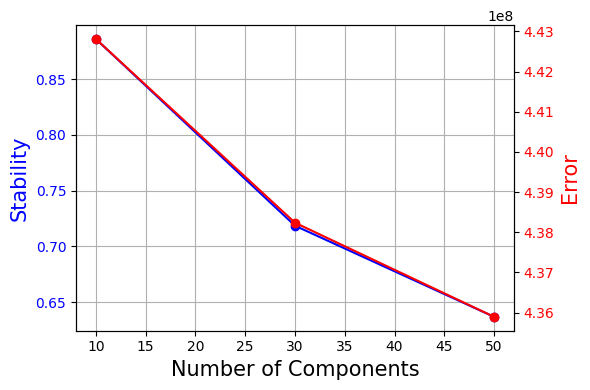

In [14]:
# Combine outputs
cnmf_obj = init_cnmf_obj(output_dir='output/', name='consensus_NMF')

cnmf_obj.combine()

# Plot stability vs error
cnmf_obj.k_selection_plot()

Running cNMF:   0%|          | 0/3 [00:00<?, ?it/s]

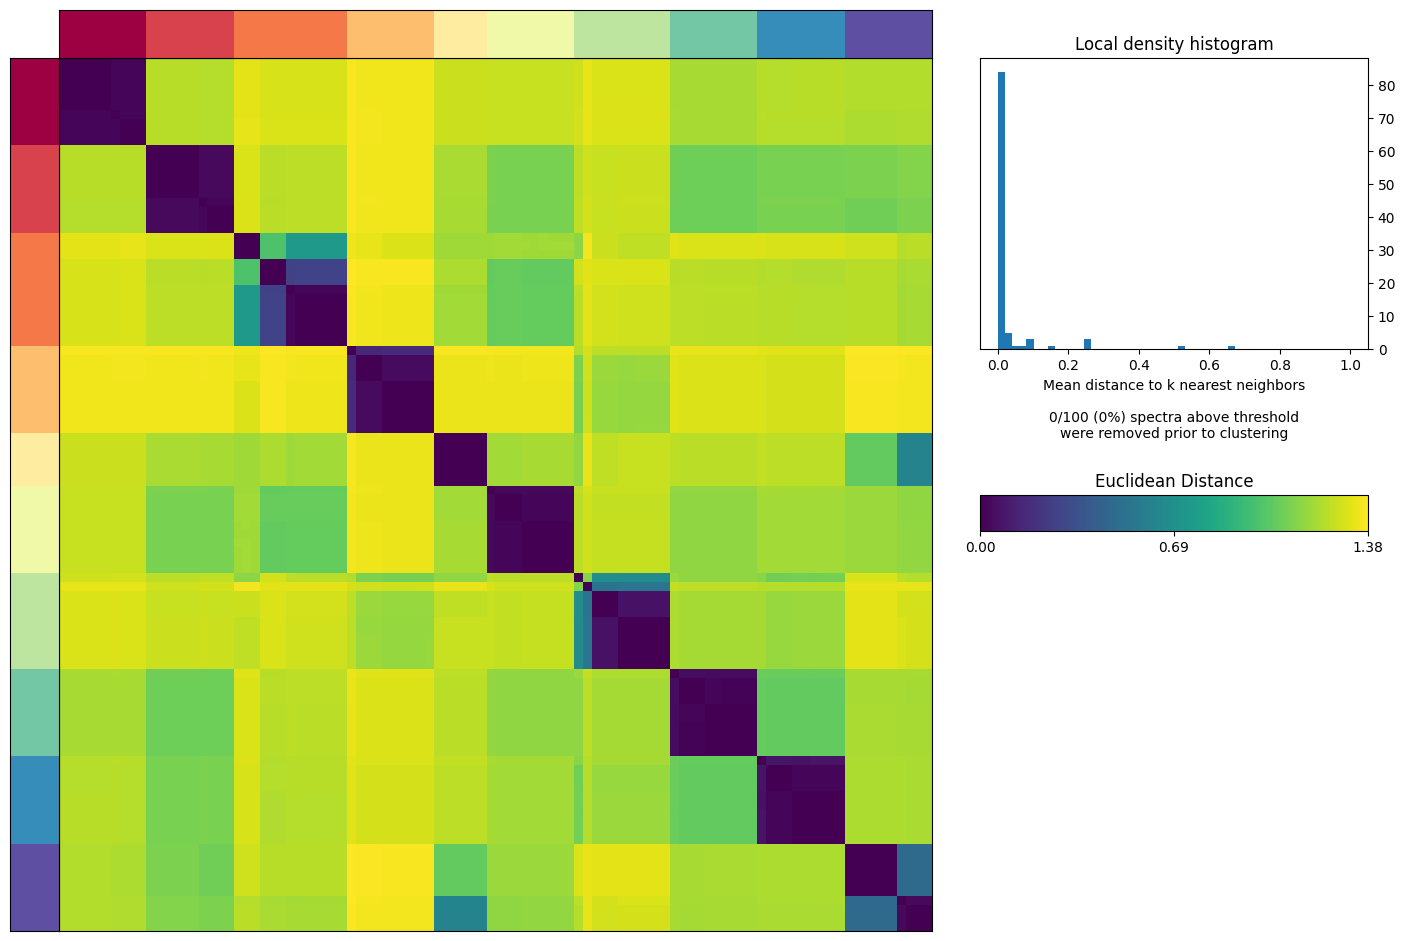

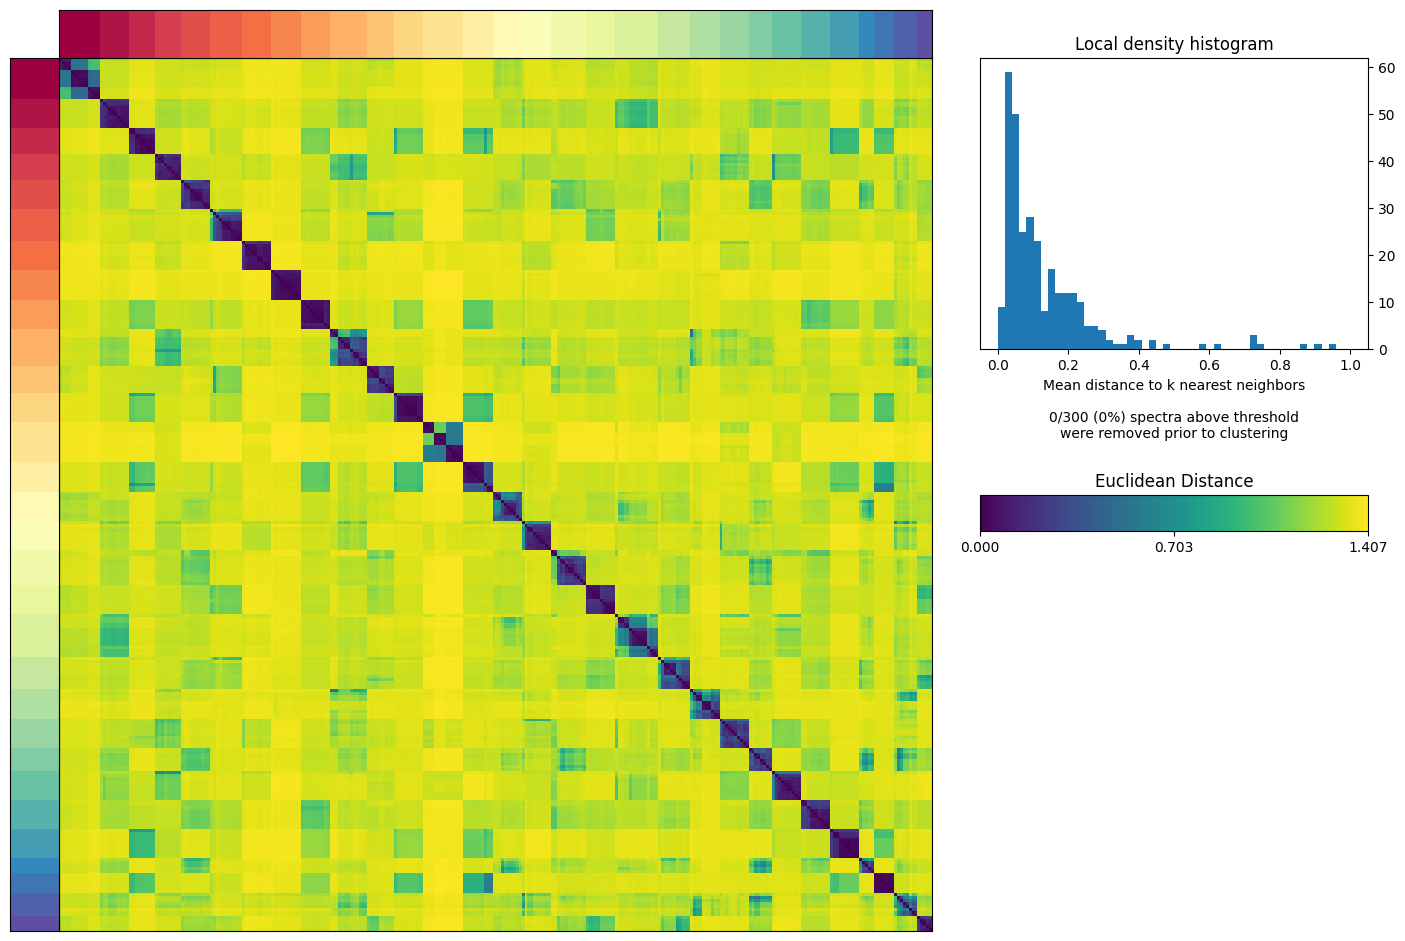

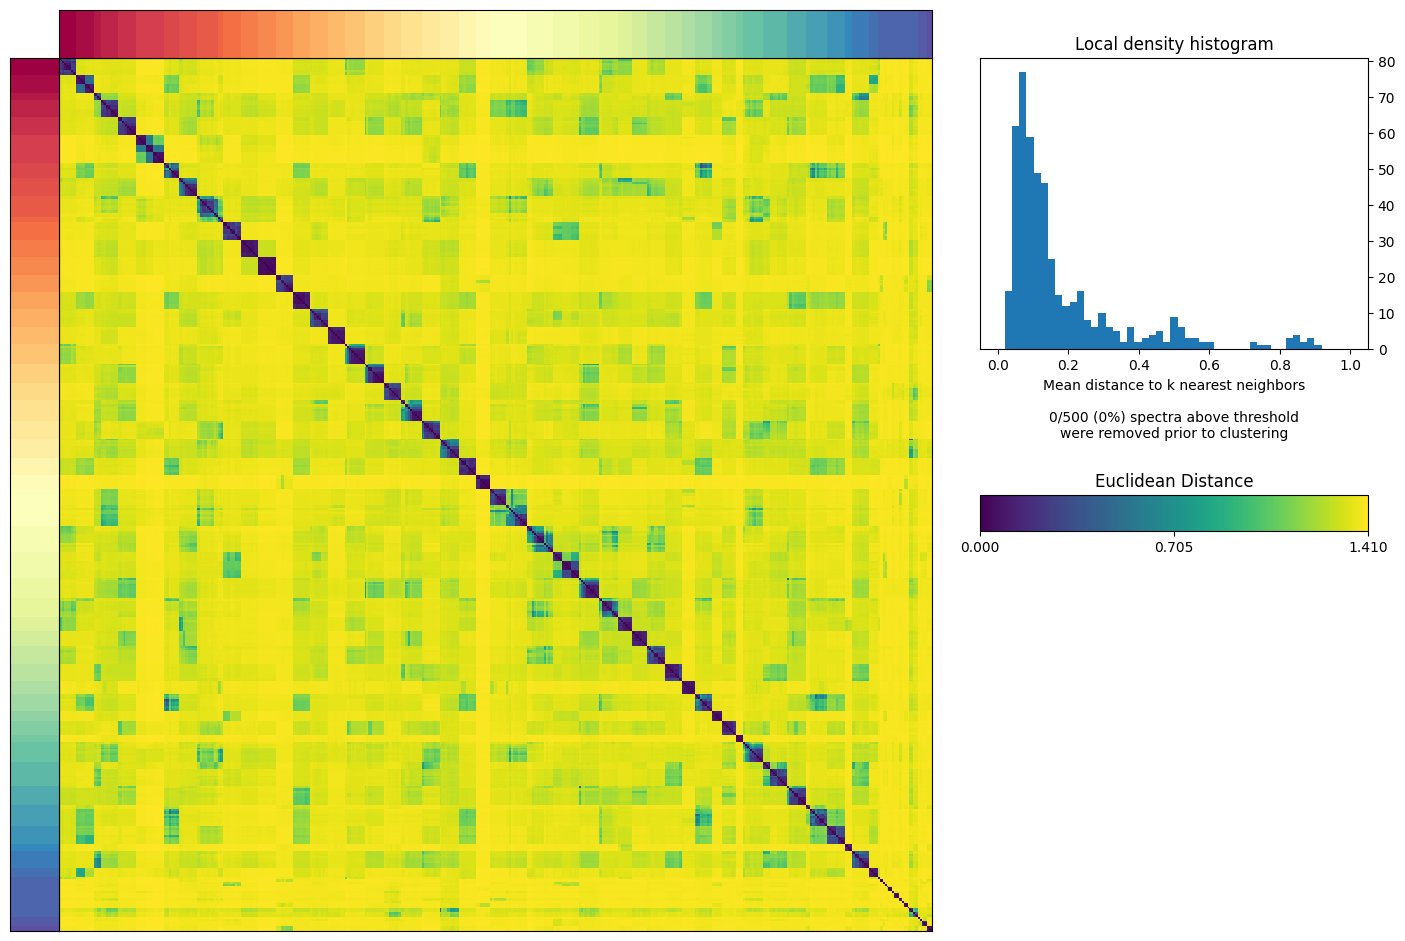

In [15]:
# Choose optimal thresholds by examining the mean distance distribution
run_cnmf_consensus(cnmf_obj, 
                   components=components, 
                   density_thresholds=[2.0])

Running cNMF:   0%|          | 0/3 [00:00<?, ?it/s]

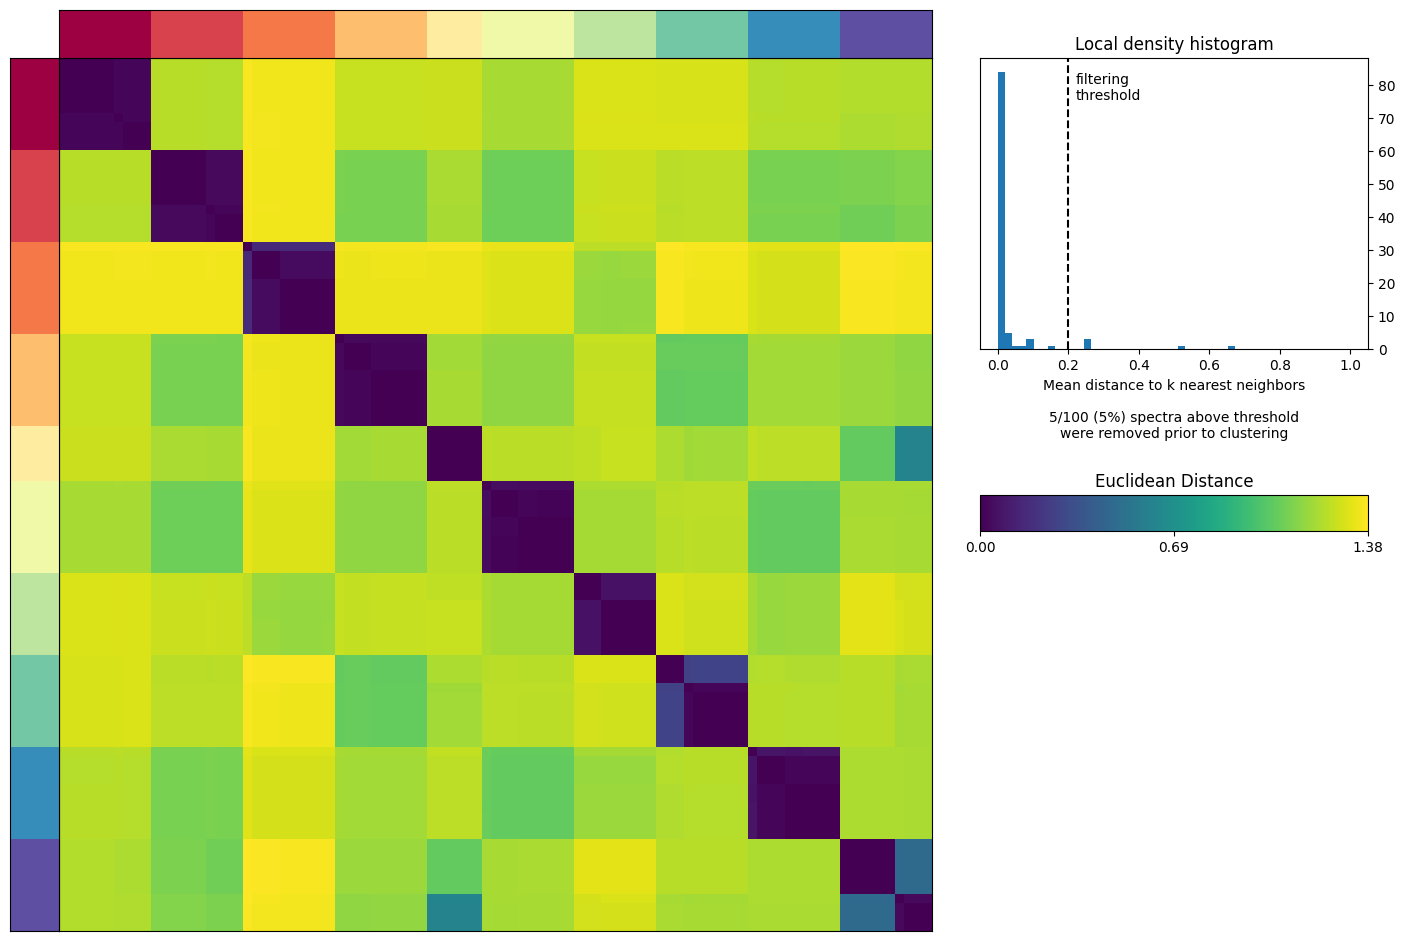

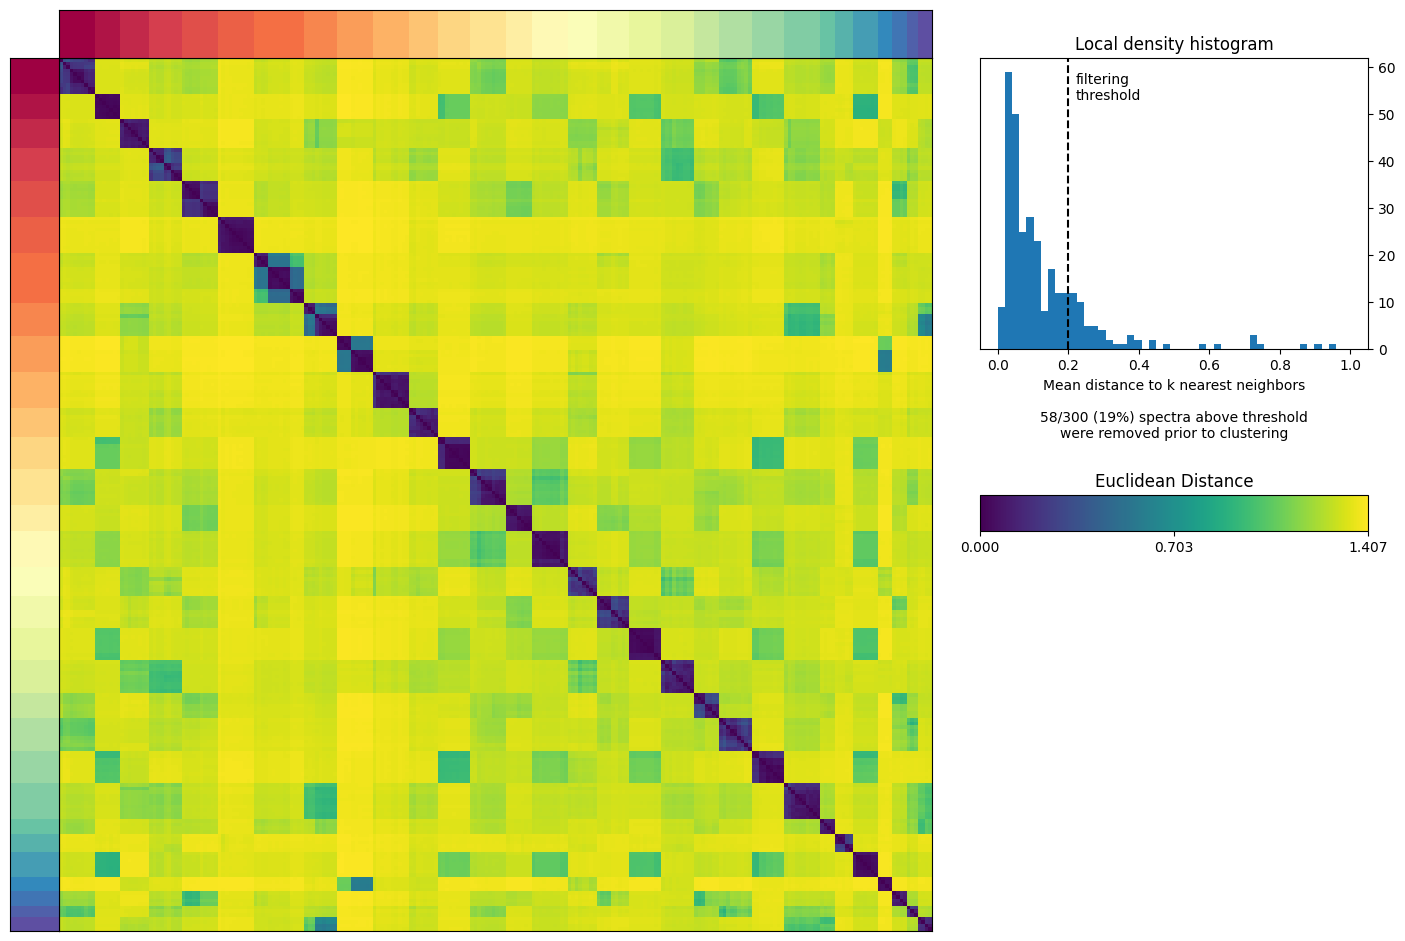

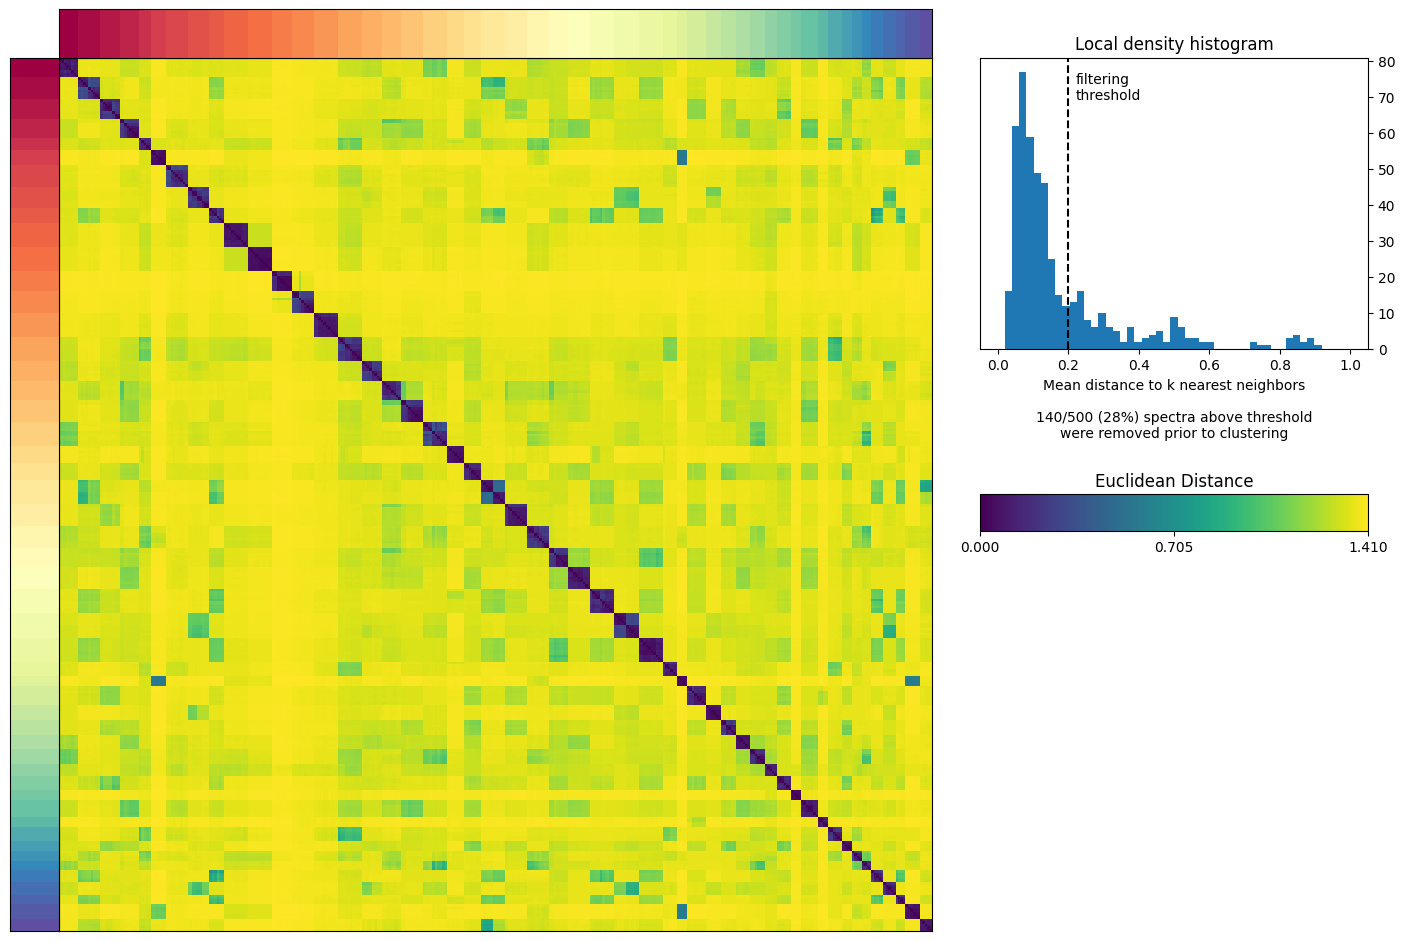

In [16]:
# Produce final decomp
sel_thresh = 0.2
run_cnmf_consensus(cnmf_obj, 
                   components=components, 
                   density_thresholds=[sel_thresh])

In [19]:
# Save all cNMF scores in separate mudata objects
for k in components:

    scores = pd.read_csv('output/consensus_NMF/consensus_NMF.usages.k_{}.dt_{}.consensus.txt'.format(
                                                                                    k,
                                                                                    str(sel_thresh).replace('.','_')),
                                                                                    sep='\t', index_col=0)

    loadings = pd.read_csv('output/consensus_NMF/consensus_NMF.spectra.k_{}.dt_{}.consensus.txt'.format(
                                                                                        k,
                                                                                        str(sel_thresh).replace('.','_')),
                                                                                        sep='\t', index_col=0)
        
    scores.to_csv('cNMF_scores_{}_{}.txt'.format(k, sel_thresh), sep='\t')
    loadings.T.to_csv('cNMF_loadings_{}_{}.txt'.format(k, sel_thresh), sep='\t')

    adata_ = anndata.read('output/consensus_NMF/cnmf_tmp/consensus_NMF.tpm.h5ad'.format(k))
    adata_.var_names_make_unique()
    adata_.obs_names_make_unique()

    prog_data = anndata.AnnData(X=scores.values, obs=adata_.obs)
    prog_data.varm['loadings'] = loadings.values
    prog_data.uns['var_names'] = loadings.columns.values

    prog_data.write('cNMF_{}_{}.h5ad'.format(k, sel_thresh))

    # Make mdata
    mdata = mudata.MuData({'rna': adata_, 'cNMF': prog_data})
    mdata.write('cNMF_{}_{}.h5mu'.format(k, sel_thresh))